In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from art.utils import load_mnist, preprocess

import os
import copy

from utils.model import FLNet
from utils.local_train import LocalTraining
from utils.utils import Utils
from utils.fusion import Fusion, FusionAvg, FusionRetrain

In [2]:
TRAIN=False
COMPUTE_HESSIAN=True
save_path = 'models/model.pt'
load_path = 'models/model.pt'

#### FL Fusion Class Selection

In [3]:
def FL_round_fusion_selection(num_parties, fusion_key='FedAvg'):

    fusion_class_dict = {
        'FedAvg': FusionAvg(num_parties),
        'Retrain': FusionRetrain(num_parties),
        'Unlearn': FusionAvg(num_parties)
        }

    return fusion_class_dict[fusion_key]

#### Set up No. of Parties, Party to be Erased, and Attack Parameters

In [4]:
num_parties = 5
scale = 1
#Select the party that I would like to erase (ex: 3)
party_to_be_erased = 0

num_samples_erased_party = int(60000 / num_parties * scale)
num_samples_per_party = int((60000 - num_samples_erased_party)/(num_parties - 1))
print('Number of samples erased party:', num_samples_erased_party)
print('Number of samples other party:', num_samples_per_party)

Number of samples erased party: 12000
Number of samples other party: 12000


### 2. Load data
<a id='section_2'></a>

In [5]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

x_train, y_train = preprocess(x_raw, y_raw)
x_test, y_test = preprocess(x_raw_test, y_raw_test)

n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

Create Trainloader

In this Notebook we are going to create it by the following principle:
 - Each client will have 50% of it's dataset given by classes common among all the clients
 - Remaining 50% will be given to each client and will be different among different clients

Example:
client 3 will have 50% given by the labels: [0,1,2,3,4]. 50% will be with data coming just from the label [7]

In [6]:
all_indices = np.arange(len(y_train))
common_classes_indices = all_indices[np.sum(y_train*np.array([1,1,1,1,1,0,0,0,0,0]), axis = 1).astype(bool)]
list_clients_dataset_indices = np.split(common_classes_indices[:-(len(common_classes_indices)%5)], 5)

for i in range(5,10):
  label = [0,0,0,0,0,0,0,0,0,0]
  label[i] = 1
  indx = all_indices[np.sum(y_train*np.array(label), axis = 1).astype(bool)]
  list_clients_dataset_indices[i-5] = np.concatenate((list_clients_dataset_indices[i-5], indx[:len(indx)//5]))

x_train_ch = np.expand_dims(x_train, axis=1)
y_train_c = np.argmax(y_train, axis=1).astype(int)
trainloader_lst = []
for indices in list_clients_dataset_indices:
  ds = TensorDataset(torch.Tensor(x_train_ch[indices]), torch.Tensor(y_train_c[indices]).long())
  trainloader_lst.append(DataLoader(ds, batch_size=128, shuffle=True))

x_test_pt = np.expand_dims(x_test, axis = 1)
y_test_pt = np.argmax(y_test,axis=1).astype(int)
dataset_test = TensorDataset(torch.Tensor(x_test_pt), torch.Tensor(y_test_pt).long())
testloader = DataLoader(dataset_test, batch_size=1000, shuffle=False)

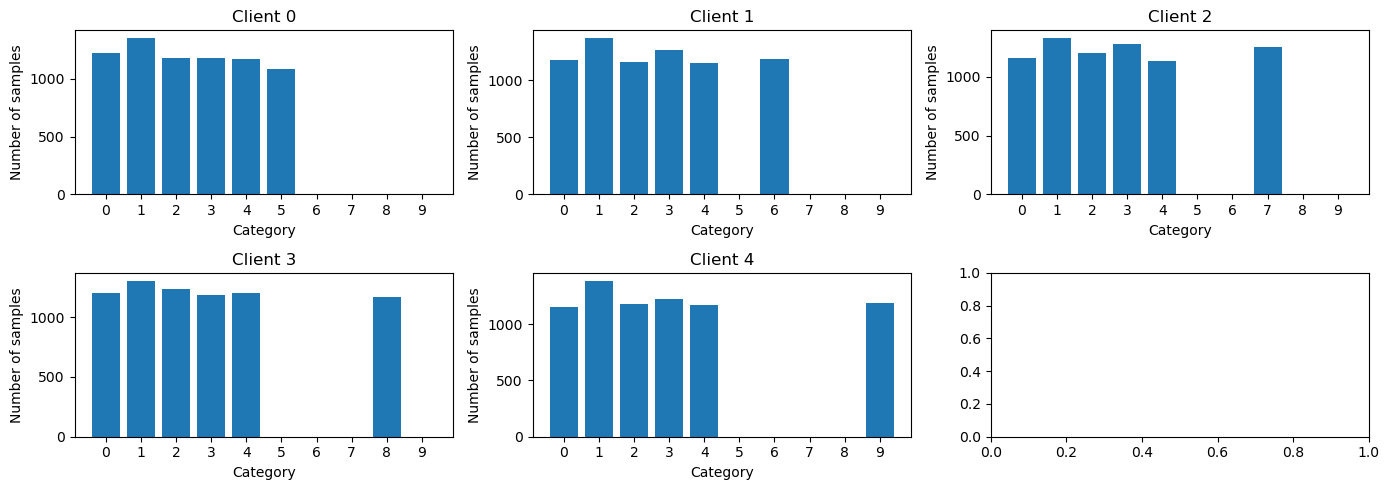

In [7]:
client_stats=[[]for i in range(5)]
for client in range(5):
    for category in range(10):
        client_indices=list_clients_dataset_indices[client]
        count=0
        for i in client_indices:
            if y_train_c[i]==category:
                count+=1
        client_stats[client].append(count)

axs = fig, axs = plt.subplots(2, 3, figsize=(14, 5))
for i,client in enumerate(client_stats):
    axs[i//3][i%3].bar(range(10),client)
    axs[i//3][i%3].set_title('Client '+str(i))
    axs[i//3][i%3].set_xticks(range(10))
    axs[i//3][i%3].set_xticklabels(range(10))
    axs[i//3][i%3].set_xlabel('Category')
    axs[i//3][i%3].set_ylabel('Number of samples')

plt.tight_layout()
plt.show()


## 2. Train the FL Model
<a id='section_3'></a>

In [8]:
num_of_repeats = 1
num_fl_rounds = 50

#fusion_types = ['FedAvg','Retrain']
fusion_types = ['FedAvg']
fusion_types_unlearn = ['Retrain', 'Unlearn']

num_updates_in_epoch = None
num_local_epochs = 1

dist_Retrain = {}
loss_fed = {}
grad_fed = {}
clean_accuracy = {}
pois_accuracy = {}
for fusion_key in fusion_types:
    loss_fed[fusion_key] = np.zeros(num_fl_rounds)
    grad_fed[fusion_key] = np.zeros(num_fl_rounds)
    clean_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    pois_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    if fusion_key != 'Retrain':
        dist_Retrain[fusion_key] = np.zeros(num_fl_rounds)

Train and evaluate the FL Model

In [9]:
class FLNet2(nn.Sequential):
    def __init__(self):
        super(FLNet2, self).__init__(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

In [10]:
if TRAIN:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device == 'cuda':
        torch.cuda.empty_cache()
    party_models_dict = {}
    initial_model = FLNet2()
    model_dict = {}

    for fusion_key in fusion_types:
        model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

    for round_num in range(num_fl_rounds):
        local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

        for fusion_key in fusion_types:
            fusion = FL_round_fusion_selection(num_parties=num_parties, fusion_key=fusion_key)

            current_model_state_dict = copy.deepcopy(model_dict[fusion_key])
            model = copy.deepcopy(initial_model)
            model.load_state_dict(current_model_state_dict)

            ##################### Local Training Round #############################
            party_models = []
            party_losses = []
            party_grad   = []        
            for party_id in range(num_parties):

                if fusion_key == 'Retrain':
                    break
                else:
                    model = copy.deepcopy(model).to(device)
                    model_update, party_loss = local_training.train(model=model,
                                                trainloader=trainloader_lst[party_id],
                                                device = device,
                                                criterion=None, opt=None)

                    party_models.append(copy.deepcopy(model_update.to('cpu')))
                    party_losses.append(party_loss)

                grad_norm = 0.0
                for param in model_update.parameters():
                    if param.grad is not None:
                        grad_norm += torch.norm(param.grad).cpu().item()
            
                party_grad.append(grad_norm)   
            
            grad_fed[fusion_key][round_num] += (np.mean(party_grad)/num_of_repeats) 

            loss_fed[fusion_key][round_num] += (np.mean(party_losses)/num_of_repeats)
            ######################################################################

            current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=model)

            model_dict[fusion_key] = copy.deepcopy(current_model_state_dict)
            party_models_dict[fusion_key] = party_models

            eval_model = FLNet2()
            eval_model.load_state_dict(current_model_state_dict)
            clean_acc = Utils.evaluate(testloader, eval_model)
            clean_accuracy[fusion_key][round_num] = clean_acc
            print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {clean_acc}')

In [11]:
if TRAIN:
    def save_model_with_unique_name(model, base_path):
        # Split the base_path into the file name and extension
        base, ext = os.path.splitext(base_path)
        new_path = base_path
        counter = 1
        
        # Check if the file exists and update the filename if needed
        while os.path.exists(new_path):
            new_path = f"{base}({counter}){ext}"
            counter += 1

        torch.save(model.state_dict(), new_path)
        print(f"Model saved to {new_path}")

    eval_model = FLNet2()
    eval_model.load_state_dict(current_model_state_dict)
    save_model_with_unique_name(eval_model, save_path)

In [12]:
saved_model = FLNet2()
saved_model.load_state_dict(torch.load(save_path, weights_only=True))

<All keys matched successfully>

In [13]:
def create_dataloader(idx_client, _list_trainloader, percentage_to_remove):
    list_trainloader = copy.deepcopy(_list_trainloader)
    client_dataset = list_trainloader[idx_client].dataset

    num_samples_to_remove = int(len(client_dataset) * percentage_to_remove)
    num_samples_to_keep = len(client_dataset) - num_samples_to_remove
    
    if num_samples_to_keep != 0:
        new_dataset = TensorDataset(client_dataset[:num_samples_to_keep][0], client_dataset[:num_samples_to_keep][1])
        list_trainloader[idx_client] = DataLoader(new_dataset, batch_size=128)

    else:
        list_trainloader.pop(idx_client)

    return list_trainloader, num_samples_to_remove

In [14]:
from torch.utils.data import ConcatDataset

def analyze_removal(_model, _trainloader_list):
    remove_percentages = np.linspace(0, 1, 10)
    trainloader_list = copy.deepcopy(_trainloader_list)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = copy.deepcopy(_model).to(device)
    criterion = nn.CrossEntropyLoss()


    # Shuffle training datasets for each client only at the beginning
    # (this is done to avoid fictitious determinism in the results)
    training_datasets = [loader.dataset for loader in trainloader_list]
    shuffled_training_datasets = []
    for dataset in training_datasets:
        indices = np.random.permutation(len(dataset))
        shuffled_training_datasets.append(TensorDataset(dataset[indices][0], dataset[indices][1]))
    shuffled_trainloader_list = [DataLoader(dataset, batch_size=128) for dataset in shuffled_training_datasets]

    results = []

    for remove_percentage in remove_percentages:

        trainloader_list, _ = create_dataloader(party_to_be_erased, shuffled_trainloader_list, remove_percentage)
        
        client_dataset = ConcatDataset([loader.dataset for loader in trainloader_list])
        loader = DataLoader(client_dataset, batch_size=128)

        loss_sum = 0
        grad_sum = torch.zeros_like(torch.cat([param.flatten() for param in model.parameters()]))
        number_of_batches = 0

        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Forward pass
            model.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Sum quantities
            loss_sum += loss.cpu().item()
            grad_sum += torch.cat([param.grad.flatten() for param in model.parameters()])
            number_of_batches += 1
            
        grad_norm = torch.norm(grad_sum).cpu().item() / number_of_batches
        loss = loss_sum / number_of_batches

        
        # Store results
        results.append({
            'removal_percentage': remove_percentage,
            'gradient_norm': grad_norm,
            'loss': loss
        })
        
        print(f"Removal percentage: {remove_percentage:.2f}")
        print(f"  - Number of samples: {sum([len(loader.dataset) for loader in trainloader_list])}")
        print(f"  - Gradient norm: {grad_norm:.4f}")
        print(f"  - Loss: {loss:.4f}")
        print("-" * 50)

    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)

    # Create plots
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot gradient norm vs Removal percentage
    axs[0].plot(results_df['removal_percentage'], results_df['gradient_norm'], 'o-')
    axs[0].set_title('Gradient Norm vs. Removal Percentage')
    axs[0].set_xlabel('Removal Percentage')
    axs[0].set_ylabel('Gradient Norm')
    axs[0].grid(True)

    # Plot loss vs Removal percentage
    axs[1].plot(results_df['removal_percentage'], results_df['loss'], 'o-')
    axs[1].set_title('Loss vs. Removal Percentage')
    axs[1].set_xlabel('Removal Percentage')
    axs[1].set_ylabel('Loss')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

#analyze_removal(saved_model, trainloader_lst)

In [15]:
# Make sure you have the proper imports
from backpack import backpack, extend
from backpack.extensions import DiagHessian

def compute_diag_hessian(model, criterion, inputs, targets, device='cpu'):
    inputs = inputs.to(device)
    targets = targets.to(device)

    model.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    with backpack(DiagHessian()):
        loss.backward()

    diag_hessian_params = {}
    for name, param in model.named_parameters():
        if hasattr(param, 'diag_h'):
            if param.requires_grad:
                diag_hessian_params[name] = param.diag_h.clone().detach()
                del param.diag_h

    return diag_hessian_params

def calculate_accumulated_diag_hessian(dataloader_list, model, criterion, weights=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    # Store Hessians and batch counts per client
    client_hessians = []
    total_batches = 0

    # Calculate diagonal Hessian for each client
    for loader_idx, loader in enumerate(dataloader_list):
        accumulated_diag_h = {}
        print(f"Calculating diagonal Hessian for client {loader_idx}")
        
        for batch_idx, (inputs, targets) in enumerate(loader):
            # Compute diagonal Hessian for this batch
            diag_h = compute_diag_hessian(model, criterion, inputs, targets, device=device)
            
            # Accumulate values
            for name, value in diag_h.items():
                if name not in accumulated_diag_h:
                    accumulated_diag_h[name] = value
                else:
                    accumulated_diag_h[name] += value
            
            total_batches += 1
        
        # Store results for this client
        client_hessians.append(accumulated_diag_h)


    # Normalize client importance weights
    if weights is None:
        weights = [1.0] * len(dataloader_list)

    # Weighted average of client Hessians
    weighted_avg_hessian = {}
    for name in client_hessians[0].keys():
        weighted_avg_hessian[name] = sum(
            client_hessians[i][name] * weights[i] for i in range(len(client_hessians))
        ) / total_batches
    
    return weighted_avg_hessian


In [16]:
trainloader_list = [DataLoader(dloader.dataset, batch_size=128) for dloader in trainloader_lst]
#trainloader_list_removed, num_removed = create_dataloader(party_to_be_erased, trainloader_list, 0.8) 

#Use the model if coming from the training or load if you have it downloaded
final_model = copy.deepcopy(saved_model)
final_model = extend(final_model)

criterion = nn.CrossEntropyLoss()
criterion = extend(criterion)

special_weight = 0.01

# Calculate equal weights for others
other_weight = 1

# Create weights list
weights = [other_weight] * len(trainloader_list)
weights[party_to_be_erased] = special_weight


Compute Hessians

In [17]:
if COMPUTE_HESSIAN:
    accumulated_diag_h = calculate_accumulated_diag_hessian(trainloader_list, final_model, criterion)
    accumulated_diag_h_removed = calculate_accumulated_diag_hessian(trainloader_list, final_model, criterion, weights)


Calculating diagonal Hessian for client 0
Calculating diagonal Hessian for client 1
Calculating diagonal Hessian for client 2
Calculating diagonal Hessian for client 3
Calculating diagonal Hessian for client 4
Calculating diagonal Hessian for client 0
Calculating diagonal Hessian for client 1
Calculating diagonal Hessian for client 2
Calculating diagonal Hessian for client 3
Calculating diagonal Hessian for client 4


In [18]:
# Make sure you have the proper imports
from backpack import backpack, extend
from backpack.extensions import DiagHessian

def compute_diag_hessian(model, criterion, inputs, targets, device="cuda"):
    inputs = inputs.to(device)
    targets = targets.to(device)

    model.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    with backpack(DiagHessian()):
        loss.backward()

    diag_hessian_params = {}
    for name, param in model.named_parameters():
        if hasattr(param, 'diag_h'):
            if param.requires_grad:
                diag_hessian_params[name] = param.diag_h.clone().detach()
                del param.diag_h

    return diag_hessian_params

def calculate_accumulated_diag_hessian_bis(loader, model, criterion, weights=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    total_batches = 0
    for batch_idx, (inputs, targets) in enumerate(loader):
        # Compute diagonal Hessian for this batch
        diag_h = compute_diag_hessian(model, criterion, inputs, targets, device=device)
        
        # Accumulate values
        for name, value in diag_h.items():
            if name not in accumulated_diag_h:
                accumulated_diag_h[name] = value
            else:
                accumulated_diag_h[name] += value
        
        total_batches += 1
        
    return accumulated_diag_h

In [ ]:
def compute_diag_hessian_naive_subset(model, criterion, dataloader, device='cpu'):
    """
    Compute the diagonal of the Hessian for a subset of parameters (here: "0.weight", "3.weight", "3.bias")
    using a naive approach. Only the allowed parameters are used in the Hessian computation,
    reducing memory usage.
    """
    # Define the allowed parameter names:
    allowed_names = ["7.weight"]#["0.weight", "3.weight", "9.weight"]
    
    device = 'cuda' if torch.cuda.is_available() else device
    model.to(device)

    accumulated_diag_h = {}
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Filter model parameters to only those in allowed_names
        allowed_named_params = [(name, param) for name, param in model.named_parameters() if name in allowed_names]
        allowed_params = [param for name, param in allowed_named_params]
        
        # Compute first derivatives for the allowed parameters with create_graph=True for second derivatives.
        grads = torch.autograd.grad(loss, allowed_params, create_graph=True)

        diag_hessian = {}
        
        # For each allowed parameter, compute the element-wise second derivative (diagonal).
        for (name, param), grad_param in zip(allowed_named_params, grads):
            if not param.requires_grad:
                continue

            grad_param_flat = grad_param.contiguous().view(-1)
            diag_elements = []

            for i in range(grad_param_flat.size(0)):
                # Compute the second derivative of grad_param_flat[i] with respect to param.
                second_deriv = torch.autograd.grad(
                    grad_param_flat[i],
                    param,
                    retain_graph=True
                )[0]
                diag_i = second_deriv.view(-1)[i]
                diag_elements.append(diag_i.detach())

            diag_tensor = torch.stack(diag_elements).view(param.size())
            diag_hessian[name] = diag_tensor.cpu()

        for name, value in diag_hessian.items():
            if name not in accumulated_diag_h:
                accumulated_diag_h[name] = value.clone()
            else:
                accumulated_diag_h[name] += value

    return diag_hessian

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 11.65 GiB is allocated by PyTorch, and 1021.71 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
#Computation of Hessian for Dataloader 0 with Backpack
hes_0 = calculate_accumulated_diag_hessian_bis(trainloader_list[0], final_model, criterion)

#Computation of Hessian for Dataloader 0 with True Hessian
final_model = copy.deepcopy(saved_model)
criterion = nn.CrossEntropyLoss()

diag_hess = compute_diag_hessian_naive_subset(final_model, criterion, trainloader_list[0], device='cuda')
for name, diag_val in diag_hess.items():
    print(f"Param: {name}, Hessian diagonal shape = {diag_val.shape}")
    print(diag_val)


In [ ]:
import torch.nn.functional as F

mse = F.mse_loss(hes_0["0.weight"].cpu(), diag_hess["0.weight"].cpu(), reduction='none')  # shape: [32, 1, 5, 5]
per_sample_mse = mse.view(32, -1).mean(dim=1)  
print(per_sample_mse.mean())

rel_error = (hes_0["0.weight"].cpu() - diag_hess["0.weight"].cpu()).abs() / (diag_hess["0.weight"].abs())  # shape: [32, 1, 5, 5]
rel_error_per_sample = rel_error.view(32, -1).mean(dim=1)
print(rel_error_per_sample)

tensor(1.4524e-05)
tensor(0.0140)
tensor([  91.5296,   65.0757,  103.9751, 2502.5317,   43.6319,  176.9136,
         121.6272,   25.6781,   36.9404,   51.1104,   35.9400,   54.4431,
          62.4935,   21.9108,   84.9790,   44.3573,  121.6477,   87.8692,
          34.1538,   59.7291,   96.9662,   53.1176,  163.1805,   47.2024,
          86.2189,   37.2162,   57.4116,   26.0272,   23.1469,   15.2220,
          18.5192,   63.3218])
tensor([nan, inf, inf, nan, nan, inf, nan, nan, inf, nan, nan, inf, inf, nan, inf, inf, nan, inf, inf, nan, nan, inf, nan, nan,
        inf, nan, nan, inf, inf, nan, inf, inf])


5120
5120
80
870


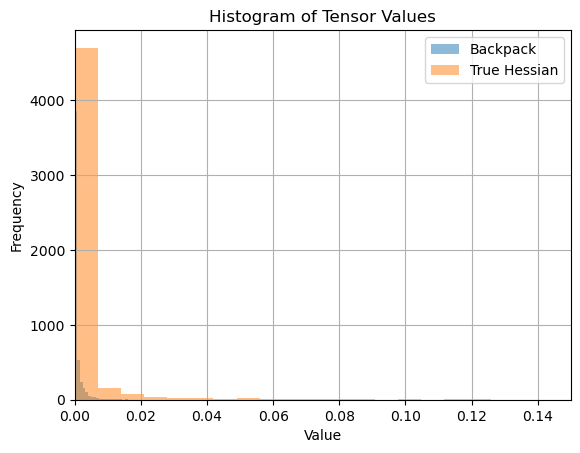

In [ ]:
flat_a = hes_0["0.weight"].view(-1).cpu().numpy()
flat_b = diag_hess["0.weight"].view(-1).cpu().numpy()

# Plot histograms
plt.hist(flat_a, bins=50, alpha=0.5, label='Backpack')
plt.hist(flat_b, bins=50, alpha=0.5, label='True Hessian')
plt.legend()
plt.title("Histogram of Tensor Values")
plt.xlabel("Value")
plt.xlim(0, 0.15)
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


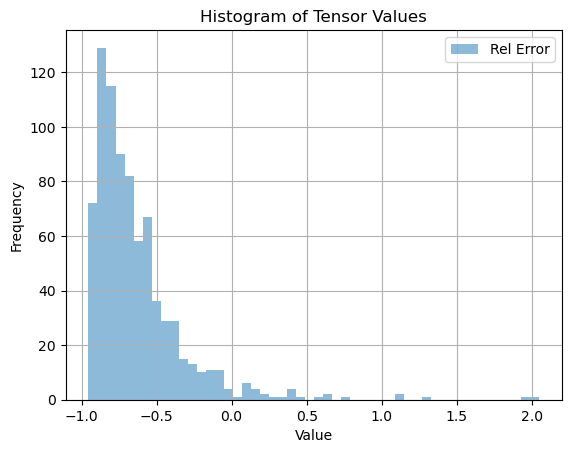

In [118]:
flat_a = (hes_0["0.weight"].cpu() - diag_hess["0.weight"].cpu())/ diag_hess["0.weight"]                                                         
flat_a = flat_a.view(-1).cpu().numpy()
# Plot histograms
plt.hist(flat_a, bins=50, alpha=0.5, label='Rel Error')
plt.legend()
plt.title("Histogram of Tensor Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

OUR METHOD

In [395]:
def compute_true_info(hessian, hessian_removed, num_removed):
    A_list = [torch.empty_like(p) for p in hessian.values()]
    B_list = [torch.empty_like(p) for p in hessian.values()]
    for i,k in enumerate(hessian.keys()): 
        print(k)

        degeneracies_indices = torch.logical_or(hessian[k]==0,hessian_removed[k]==0)
        print(f"Number of degenaracies: {torch.sum(degeneracies_indices)}")

        ratio = hessian_removed[k]/hessian[k]
        A=1/2 * torch.log(ratio)/num_removed
        B=1/2 * (1-ratio)/num_removed

        A[degeneracies_indices]=0
        B[degeneracies_indices]=0

        assert torch.sum(torch.isnan(A))==0, f"NaN values in A: {torch.sum(torch.isnan(A))}"
        assert torch.sum(torch.isnan(B))==0, f"NaN values in B: {torch.sum(torch.isnan(B))}"
        assert torch.sum(torch.isinf(A))==0, f"Inf values in A: {torch.sum(torch.isinf(A))}"
        assert torch.sum(torch.isinf(B))==0, f"Inf values in B: {torch.sum(torch.isinf(B))}"

        A_list[i]=A
        B_list[i]=B

    C = sum([torch.sum(A_list[i]+B_list[i]).item() for i in range(len(A_list))])

    information_true=[(A_list[i]+B_list[i])*C + 2*torch.pow(B_list[i],2) for i in range(len(hessian.keys()))]

    return information_true

In [396]:
if COMPUTE_HESSIAN:  
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    #info_true = compute_true_info(accumulated_diag_h, accumulated_diag_h_removed, torch.as_tensor(special_weight))
    info_true = compute_true_info(accumulated_diag_h, accumulated_diag_h_removed, torch.as_tensor([1]).to(device))

0.weight
Number of degenaracies: 0
0.bias
Number of degenaracies: 0
3.weight
Number of degenaracies: 0
3.bias
Number of degenaracies: 0
7.weight
Number of degenaracies: 61029
7.bias
Number of degenaracies: 8
9.weight
Number of degenaracies: 80
9.bias
Number of degenaracies: 0


In [397]:
if COMPUTE_HESSIAN:
    import pickle

    with open('cached/info_true.pkl', 'wb') as f:
        pickle.dump(info_true, f)

Load hessians

In [398]:
import pickle
with open('cached/info_true.pkl', 'rb') as f:
    info_true = pickle.load(f)

In [399]:
def sum_information_values(information):
    # Initialize an empty list to store all flattened tensors
    all_values = []

    # Iterate through each parameter's information tensor
    for tensor in information:
        # Flatten the tensor and add to our list
        temp=torch.nan_to_num(tensor.flatten())
        temp = temp[torch.isinf(temp)==0]
        temp = temp[temp!=0]
        all_values.append(temp)

    # Concatenate all tensors into one large tensor
    combined_tensor = torch.cat(all_values)
    print(len(combined_tensor))
    return combined_tensor

def plot_information(information):
    combined_tensor = sum_information_values(information)

    # Convert to numpy for plotting
    values = combined_tensor.detach().cpu().numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))

    #Histogram
    plt.subplot(1, 2, 1)
    plt.hist(values, alpha=0.7, bins=50)
    plt.title('Distribution of Information Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Exclude outliers for the second plot (optional)
    q1, q3 = np.percentile(values, [0, 98])
    iqr = q3 - q1
    # lower_bound = q1 - 1.5 * iqr
    # upper_bound = q3 + 1.5 * iqr
    lower_bound = q1
    upper_bound = q3
    filtered_values = values[(values >= lower_bound) & (values <= upper_bound)]
    print(f"Number of outliers: {len(values) - len(filtered_values)}")

    # Filtered histogram (without outliers)
    plt.subplot(1, 2, 2)
    plt.hist(filtered_values, alpha=0.7, bins=30, color='green')
    plt.title('Distribution (Outliers Removed)')
    plt.xlabel('Value')

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"Sum of all information values: {combined_tensor.sum().item():.6f}")
    print(f"Mean: {combined_tensor.mean().item()}")
    print(f"Min: {combined_tensor.min().item()}")
    print(f"Max: {combined_tensor.max().item()}")
    print(f"Total number of values: {len(values)}")

    print(f"Sum of all information values: {filtered_values.sum().item():.6f}")
    print(f"Mean: {filtered_values.mean().item()}")
    print(f"Min: {filtered_values.min().item()}")
    print(f"Max: {filtered_values.max().item()}")
    print(f"Total number of values: {len(filtered_values)}")

    return combined_tensor.sum().item(), filtered_values.sum().item()

1561743
Number of outliers: 31235


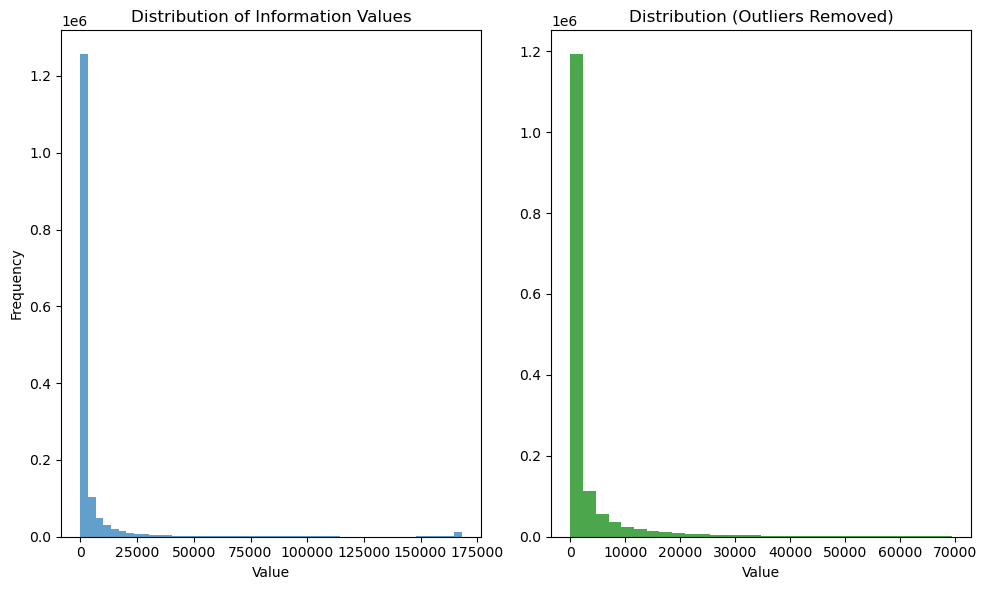

Sum of all information values: 8665730048.000000
Mean: 5548.75537109375
Min: 1.7763568394002505e-15
Max: 168267.75
Total number of values: 1561743
Sum of all information values: 4513673216.000000
Mean: 2949.134033203125
Min: 1.7763568394002505e-15
Max: 69367.3203125
Total number of values: 1530508


(8665730048.0, 4513673216.0)

In [400]:
plot_information(info_true)

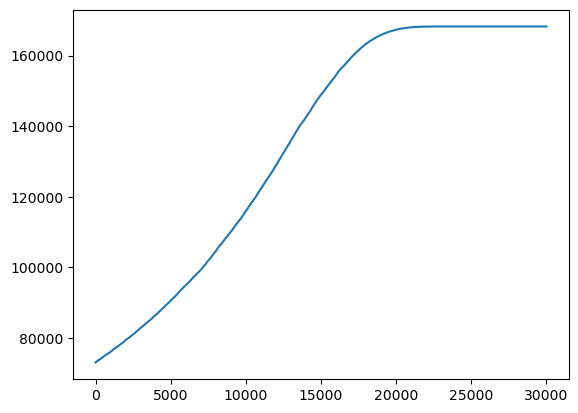

In [401]:
info_true=[p.cpu() for p in info_true]
infocat = torch.cat([p.flatten() for p in info_true])
s_infocat = np.sort(torch.nan_to_num(infocat))

#Find elbow
# from kneed import KneeLocator
# kl = KneeLocator(range(len(s_infocat)), s_infocat, curve='convex', direction='increasing')
# #kl.plot_knee()
# informative_params = len(s_infocat)-kl.knee
# print(f"Number of informative parameters: {informative_params}")

n=40 # print the last n*informative_params parameters
#plt.plot(s_infocat[-informative_params*n:])
plt.plot(s_infocat[-30000:])
##Plot the knee
#plt.axvline(informative_params*(n-1), color='red', linestyle='--')
plt.show()


Parameters reset unlearning

In [402]:
treshold = s_infocat[-10000]

retrain_param_indices = [torch.argwhere(p >= treshold) for p in info_true]

model_reset = copy.deepcopy(saved_model).cpu()
model_null = FLNet2()

original_parameters = model_reset.state_dict()
null_parameters = model_null.state_dict()

reset_parameters = {}
for i, (name, p) in enumerate(model_reset.named_parameters()):
    new_p = original_parameters[name].clone()
    null_p = null_parameters[name].clone()
    new_p[tuple(retrain_param_indices[i].t())] = null_p[tuple(retrain_param_indices[i].t())]
    reset_parameters[name] = new_p

model_reset.load_state_dict(reset_parameters)


# Compute accuracy for each client
def compute_accuracy(model, testloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return 100 * correct / total

def compute_accuracy_per_client(model, testloader_list):
    accuracies = []
    for i, testloader in enumerate(testloader_list):
        acc = compute_accuracy(model, testloader)
        accuracies.append(acc)
        print(f"Accuracy for client {i}: {acc:.2f}%")

print("Accuracy before resetting:")
compute_accuracy_per_client(saved_model, trainloader_lst)
print("Accuracy after resetting:")
compute_accuracy_per_client(model_reset, trainloader_lst)



Accuracy before resetting:
Accuracy for client 0: 99.38%
Accuracy for client 1: 99.81%
Accuracy for client 2: 99.43%
Accuracy for client 3: 98.81%
Accuracy for client 4: 98.44%
Accuracy after resetting:
Accuracy for client 0: 99.38%
Accuracy for client 1: 99.81%
Accuracy for client 2: 99.43%
Accuracy for client 3: 98.81%
Accuracy for client 4: 98.44%


In [403]:
import torch
import torch.nn as nn

class UnlearnNet(nn.Module):
    """
    A module that wraps an existing model and selectively retrains individual 
    scalar elements (indices) of its parameters while keeping the rest fixed.
    """

    def __init__(self, base_model, indices_to_retrain):
        """
        Args:
            base_model (nn.Module): The original model whose parameters 
                                    we want to partially retrain.
            indices_to_retrain (List[torch.Tensor]): For each parameter of 
                                    'base_model', a tensor of indices indicating 
                                    which scalar values should be retrained.
        """
        super().__init__()

        # We store the base model inside a dictionary to allow
        # functional calls later without overshadowing state_dict keys.
        self.inner_model = {"model": base_model}

        # Move any index tensors to CPU and store them.
        self.indices_to_retrain = [idx.cpu() for idx in indices_to_retrain]

        # Create a copy of the base model's parameters as buffers, where
        # we zero out the positions that will be retrained.
        base_params = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            # Detach a clone of the original parameter
            cloned_param = param.clone().detach()
            # Zero-out the entries we plan to retrain
            if len(self.indices_to_retrain[i]) > 0:
                cloned_param[tuple(self.indices_to_retrain[i].t())] = 0
            base_params[param_name] = cloned_param

        # Register these base parameters as buffers so they are not optimized
        for param_name, buf in base_params.items():
            buf_name = param_name.replace(".", "_")
            self.register_buffer(f"base_{buf_name}", buf)

        # Create the new learnable parameters for only the chosen indices
        retrain_params_dict = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            if len(self.indices_to_retrain[i]) == 0:
                continue
            # We create a 1D tensor (one entry per retrained element)
            key = param_name.replace(".", "_")
            retrain_params_dict[key] = nn.Parameter(
                torch.zeros(len(self.indices_to_retrain[i]))
            )
        self.retrain_params = nn.ParameterDict(retrain_params_dict)

        # Build sparse masks to apply the learnable values at the correct indices
        sparse_masks = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            if len(self.indices_to_retrain[i]) == 0:
                continue
            # 'retrain_indices' has shape (k, n_dims). Add a final dim to index positions in the retrain-param vector.
            retrain_indices = indices_to_retrain[i]
            k = retrain_indices.size(0)

            # Create an index column [0..k-1], then concatenate it with 'retrain_indices'.
            row_idx = torch.arange(k).unsqueeze(1)
            final_idx_matrix = torch.cat([retrain_indices, row_idx], dim=1)

            # A sparse_coo_tensor expects indices with shape (ndim, nnz). Transpose to (n_dims+1, k).
            indices_for_sparse = final_idx_matrix.t().contiguous()

            # Append k as the final dimension so each retrained element indexes differently.
            mask_shape = tuple(param.size()) + (k,)

            # Build the sparse mask with 1.0 at the retrained indices.
            key = f"mask_{param_name.replace('.', '_')}"
            sparse_masks[key] = torch.sparse_coo_tensor(
                indices_for_sparse,
                torch.ones(k, dtype=torch.float32),
                size=mask_shape
            )
        
        # Register these sparse masks as buffers
        for mask_name, mask in sparse_masks.items():
            self.register_buffer(mask_name, mask.coalesce())

    def contract_last_dim_with_vector(self, sp_tensor: torch.Tensor, vec: torch.Tensor) -> torch.Tensor:
        """
        Contract the last dimension of a sparse tensor (shape [..., N]) with
        a dense vector of shape (N,), returning a sparse tensor of shape [...].

        This effectively applies elementwise multiplication with 'vec'
        across the last dimension of 'sp_tensor'.
        """

        # Extract indices (shape [ndim, nnz]) and values (shape [nnz])
        indices = sp_tensor.indices()
        values = sp_tensor.values()

        # Multiply each sparse value by the corresponding element in 'vec'
        # indices[-1] indicates which element in 'vec' to use per sparse entry
        new_values = values * vec[indices[-1]]

        # Create a new sparse_coo_tensor with one fewer dimension
        new_shape = sp_tensor.shape[:-1]
        new_indices = indices[:-1, :]  # drop the last dimension index row

        result_tensor = torch.sparse_coo_tensor(
            new_indices,
            new_values,
            size=new_shape,
            dtype=sp_tensor.dtype,
            device=sp_tensor.device
        )

        return result_tensor

    def forward(self, x):
        """
        Forward pass using a functional call to the base model. We reconstruct 
        final parameters by adding the base buffers and the contracted retrain 
        parameters at the relevant indices.
        """
        model = self.inner_model["model"]
        current_state = self.state_dict()

        # Rebuild parameter dict from buffers (base params)
        final_params = {}
        for param_name in model.state_dict().keys():
            buf_name = param_name.replace(".", "_")
            final_params[param_name] = current_state[f"base_{buf_name}"]

        # Add in the learnable values at specified indices
        for key, param_vector in self.retrain_params.items():
            mask_key = f"mask_{key}"
            base_key = f"base_{key}"
            original_param_name = key.replace("_", ".")

            # Convert sparse mask to shape that can be added to base param
            sparse_update = self.contract_last_dim_with_vector(
                current_state[mask_key], param_vector
            )

            # Add the sparse update to the base buffer
            final_params[original_param_name] = (
                current_state[base_key] + sparse_update
            )

        # Perform a functional forward pass with the reconstructed parameters
        return torch.func.functional_call(model, final_params, x)
    

In [404]:
#Test
unlearn_model = UnlearnNet(model_reset, retrain_param_indices)

print("Unlearn model parameters:")
for name , param in unlearn_model.named_parameters():
    print(name, param.shape)

print("Accuracy (reset before retrain)")
compute_accuracy_per_client(unlearn_model, trainloader_lst)


Unlearn model parameters:
retrain_params.7_bias torch.Size([1])
retrain_params.7_weight torch.Size([9981])
retrain_params.9_weight torch.Size([18])
Accuracy (reset before retrain)
Accuracy for client 0: 99.38%
Accuracy for client 1: 99.81%
Accuracy for client 2: 99.43%
Accuracy for client 3: 98.81%
Accuracy for client 4: 98.44%


In [405]:
num_of_repeats = 1
num_fl_rounds = 10

#fusion_types = ['FedAvg','Retrain']
fusion_types = ['FedAvg']
fusion_types_unlearn = ['Retrain', 'Unlearn']

num_updates_in_epoch = None
num_local_epochs = 2

dist_Retrain = {}
loss_fed = {}
grad_fed = {}
clean_accuracy = {}
pois_accuracy = {}
for fusion_key in fusion_types:
    loss_fed[fusion_key] = np.zeros(num_fl_rounds)
    grad_fed[fusion_key] = np.zeros(num_fl_rounds)
    clean_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    pois_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    if fusion_key != 'Retrain':
        dist_Retrain[fusion_key] = np.zeros(num_fl_rounds)

In [406]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.empty_cache()

party_models_dict = {}
initial_model = unlearn_model
model_dict = {}
num_parties = 4

for fusion_key in fusion_types:
    model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

for round_num in range(num_fl_rounds):
    local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

    for fusion_key in fusion_types:
        fusion = FL_round_fusion_selection(num_parties=num_parties, fusion_key=fusion_key)

        current_model_state_dict = copy.deepcopy(model_dict[fusion_key])
        model = copy.deepcopy(initial_model)
        model.load_state_dict(current_model_state_dict)

        ##################### Local Training Round #############################
        party_models = []
        party_losses = []
        party_grad   = []        
        for party_id in [0,1,2,4]:

            if fusion_key == 'Retrain':
                break
            else:
                print(f"Training party {party_id}")
                model = UnlearnNet(model_reset, retrain_param_indices)
                model.load_state_dict(current_model_state_dict)
                model.to(device)
                model_update, party_loss = local_training.train(model=model,
                                            trainloader=trainloader_lst[party_id],
                                            device = device,
                                            criterion=None, opt=None)
                model_update_copy = UnlearnNet(model_reset, retrain_param_indices)
                model_update_copy.load_state_dict(model_update.state_dict())
                model_update_copy.to("cpu")
                party_models.append(model_update_copy)
                party_losses.append(party_loss)

            grad_norm = 0.0
            for name,param in model_update.named_parameters():
                if param.grad is not None:
                    grad_norm += torch.norm(param.grad).cpu().item()
                    #print(f"Gradient norm for {name}: {grad_norm}")
                else:
                    #print(f"Gradient is None for {name}")
                    pass
        
            party_grad.append(grad_norm)   
        
        grad_fed[fusion_key][round_num] += (np.mean(party_grad)/num_of_repeats) 

        loss_fed[fusion_key][round_num] += (np.mean(party_losses)/num_of_repeats)
        ######################################################################

        current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=model)

        eval_model = copy.deepcopy(initial_model).to("cpu")
        eval_model.load_state_dict(current_model_state_dict)
        clean_acc = Utils.evaluate(testloader, eval_model)
        clean_accuracy[fusion_key][round_num] = clean_acc
        print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {clean_acc}')

Training party 0
Training party 1
Training party 2
Training party 4
Global Clean Accuracy FedAvg, round 0 = 97.44
Training party 0
Training party 1
Training party 2
Training party 4
Global Clean Accuracy FedAvg, round 1 = 97.44
Training party 0
Training party 1
Training party 2
Training party 4
Global Clean Accuracy FedAvg, round 2 = 97.44
Training party 0
Training party 1
Training party 2
Training party 4
Global Clean Accuracy FedAvg, round 3 = 97.44
Training party 0
Training party 1
Training party 2
Training party 4
Global Clean Accuracy FedAvg, round 4 = 97.44
Training party 0
Training party 1
Training party 2
Training party 4
Global Clean Accuracy FedAvg, round 5 = 97.44
Training party 0
Training party 1
Training party 2
Training party 4
Global Clean Accuracy FedAvg, round 6 = 97.44
Training party 0
Training party 1
Training party 2
Training party 4
Global Clean Accuracy FedAvg, round 7 = 97.44
Training party 0
Training party 1
Training party 2
Training party 4
Global Clean Accurac

In [407]:
print("Accuracy after retrain")
compute_accuracy_per_client(eval_model, trainloader_lst)

Accuracy after retrain
Accuracy for client 0: 99.38%
Accuracy for client 1: 99.81%
Accuracy for client 2: 99.43%
Accuracy for client 3: 98.81%
Accuracy for client 4: 98.44%


In [408]:
client0 = torch.load("client0")
client1 = torch.load("client1")
client2 = torch.load("client2")
client3 = torch.load("client3")
client4 = torch.load("client4")

# For NumPy arrays
import numpy as np

def count_equal_arrays(list1, list2):
    equal_count = 0
    min_length = min(len(list1), len(list2))
    
    for i in range(min_length):
        if np.array_equal(list1[i], list2[i]):
            print(list1[i])
            equal_count += 1
    
    return equal_count

count_equal_arrays(client4[6], client4[6])

import torch
import numpy as np

def tensor_list_distance(list1, list2, metric='euclidean'):
    """
    Compute various distance metrics between two lists of tensors.
    
    Args:
        list1: First list of tensors
        list2: Second list of tensors
        metric: Distance metric to use ('euclidean', 'manhattan', 'cosine', 'mean_squared', 'element_diff')
        
    Returns:
        float: The computed distance between the two tensor lists
    """
    # Make sure we only compare up to the length of the shorter list
    min_length = min(len(list1), len(list2))
    
    if min_length == 0:
        raise ValueError("At least one of the lists is empty")
        
    # Initialize distance
    distances = []
    
    # Compute distance for each pair of tensors
    for i in range(min_length):
        tensor1 = list1[i].float()  # Ensure tensors are float type
        tensor2 = list2[i].float()
        
        if metric == 'euclidean':
            # Euclidean distance
            dist = torch.sqrt(torch.sum((tensor1 - tensor2) ** 2)).item()
            distances.append(dist)
            
        elif metric == 'manhattan':
            # Manhattan (L1) distance
            dist = torch.sum(torch.abs(tensor1 - tensor2)).item()
            distances.append(dist)
            
        elif metric == 'cosine':
            # Cosine distance (1 - cosine similarity)
            dot_product = torch.sum(tensor1 * tensor2)
            norm1 = torch.sqrt(torch.sum(tensor1 ** 2))
            norm2 = torch.sqrt(torch.sum(tensor2 ** 2))
            
            # Avoid division by zero
            if norm1 == 0 or norm2 == 0:
                dist = 1.0  # Maximum distance
            else:
                cosine_sim = dot_product / (norm1 * norm2)
                # Clip to handle floating point errors
                cosine_sim = torch.clamp(cosine_sim, -1.0, 1.0)
                dist = 1.0 - cosine_sim.item()
                
            distances.append(dist)
            
        elif metric == 'mean_squared':
            # Mean squared error
            dist = torch.mean((tensor1 - tensor2) ** 2).item()
            distances.append(dist)
            
        elif metric == 'element_diff':
            # Count of different elements
            diff_count = torch.sum(tensor1 != tensor2).item()
            distances.append(diff_count)
            
        else:
            raise ValueError(f"Unknown distance metric: {metric}")
    
    # Compute average distance across all tensor pairs
    avg_distance = np.mean(distances)
    
    # Calculate additional statistics
    stats = {
        "mean": avg_distance,
        "median": np.median(distances),
        "min": np.min(distances),
        "max": np.max(distances),
        "std": np.std(distances),
        "distances": distances  # List of all pairwise distances
    }
    
    return stats

    
# Compute distances using different metrics
for metric in ['euclidean', 'element_diff']:
    result = tensor_list_distance(client0[4], client1[4], metric=metric)
    print(f"\n{metric.upper()} Distance:")
    print(f"Mean: {result['mean']:.6f}")
    print(f"Median: {result['median']:.6f}")
    print(f"Min: {result['min']:.6f}")
    print(f"Max: {result['max']:.6f}")
    print(f"Std: {result['std']:.6f}")


tensor([ 7, 79])
tensor([ 9, 79])
tensor([  9, 238])
tensor([  9, 353])

EUCLIDEAN Distance:
Mean: 1131.383835
Median: 1096.147827
Min: 0.000000
Max: 3125.899902
Std: 760.759157

ELEMENT_DIFF Distance:
Mean: 1.897503
Median: 2.000000
Min: 0.000000
Max: 2.000000
Std: 0.303632
